In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
df = pd.read_csv("BERT/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
round(747/4825,4)

0.1548

In [6]:
df_spam = df[df["Category"]=="spam"]
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df["Category"]=="ham"]
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced["Category"].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [11]:
df_balanced.sample(5)

,Category,Message
3394,ham,Ok thanx...
2286,ham,"Hi, wkend ok but journey terrible. Wk not good..."
531,spam,PRIVATE! Your 2003 Account Statement for 07815...
1274,spam,network operator. The service is free. For T &...
31,ham,Yeah he got in at 2 and was v apologetic. n ha...


In [12]:
df_balanced["Spam"] = df_balanced["Category"].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,Spam
3987,ham,"Friendship is not a game to play, It is not a ...",0
3992,ham,I am on the way to ur home,0
534,ham,I'll be late...,0
527,spam,Today's Offer! Claim ur £150 worth of discount...,1
3807,spam,URGENT! We are trying to contact you. Last wee...,1
147,spam,FreeMsg Why haven't you replied to my text? I'...,1
4953,spam,"Welcome to Select, an O2 service with added be...",1
4462,ham,Thanks again for your reply today. When is ur ...,0
4131,ham,And by when you're done I mean now,0
784,spam,You have an important customer service announc...,1


In [13]:
X = df_balanced["Message"]
y = df_balanced["Spam"]

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_balanced["Spam"])

In [15]:
X_train.head()

2642    You are guaranteed the latest Nokia Phone, a 4...
2094    Final Chance! Claim ur £150 worth of discount ...
3272    You have 1 new voicemail. Please call 08719181...
4848    I am in escape theatre now. . Going to watch K...
3065                           Ok. How many should i buy.
Name: Message, dtype: object

In [16]:
X_train.shape

(1120,)

## BERT

In [17]:
preprocess_url = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"
encoder_url = "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4"

In [18]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

### Sentence Embedding Function

In [19]:
 def get_sentence_embedding(input_text):
     proprocessed_output = bert_preprocess(input_text)
     encoded_text = bert_encoder(proprocessed_output)
     return encoded_text['pooled_output']

In [20]:
sample = [
    "banana",
    "grape",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]

In [21]:
sample_output = get_sentence_embedding(sample)
sample_output

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606918 , -0.1421939 ,  0.49604574, ...,  0.42165288,
        -0.5322141 ,  0.8031218 ],
       [-0.854085  , -0.17408381,  0.23000923, ...,  0.22893827,
        -0.55810875,  0.8516548 ],
       [-0.7128861 , -0.154639  ,  0.38401738, ...,  0.35278767,
        -0.50991327,  0.734741  ],
       [-0.82533467, -0.35550553, -0.5906963 , ..., -0.01613665,
        -0.61417556,  0.872303  ],
       [-0.7504136 , -0.2681262 , -0.26689762, ...,  0.0283935 ,
        -0.59380996,  0.7974989 ],
       [-0.78544384, -0.29949707,  0.4102738 , ...,  0.5222538 ,
        -0.49573562,  0.81507534]], dtype=float32)>

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([sample_output[0]],[sample_output[1]])

array([[0.9718795]], dtype=float32)

#### Here 
- sample_output[0] = banana
- sample_output[1] = grape
#### *Similarity between them is 97.19%*

In [23]:
cosine_similarity([sample_output[0]],[sample_output[3]])

array([[0.8470387]], dtype=float32)

In [24]:
cosine_similarity([sample_output[3]],[sample_output[4]])

array([[0.98720354]], dtype=float32)

 ### Let's get into Spam message classification

In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
output = tf.keras.layers.Dropout(0.1, name="dropout")(outputs["pooled_output"])
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(output)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[output])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [27]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=METRICS)

In [28]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 104s 3s/step - loss: 0.6608 - accuracy: 0.6098 - precision: 0.6070 - recall: 0.6232
Epoch 2/10
35/35 [==============================] - 99s 3s/step - loss: 0.5237 - accuracy: 0.7830 - precision: 0.8042 - recall: 0.7482
Epoch 3/10
35/35 [==============================] - 98s 3s/step - loss: 0.4466 - accuracy: 0.8491 - precision: 0.8179 - recall: 0.8982
Epoch 4/10
35/35 [==============================] - 98s 3s/step - loss: 0.3966 - accuracy: 0.8607 - precision: 0.8495 - recall: 0.8768
Epoch 5/10
35/35 [==============================] - 98s 3s/step - loss: 0.3566 - accuracy: 0.8813 - precision: 0.8650 - recall: 0.9036
Epoch 6/10
35/35 [==============================] - 97s 3s/step - loss: 0.3339 - accuracy: 0.8902 - precision: 0.8800 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 97s 3s/step - loss: 0.3162 - accuracy: 0.8938 - precision: 0.8795 - recall: 0.9125
Epoch 8/10
35/35 [==============================] - 98

In [29]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 33s 3s/step - loss: 0.3010 - accuracy: 0.8850 - precision: 0.8750 - recall: 0.8984


[0.3009542226791382, 0.885026752948761, 0.875, 0.8983957171440125]

In [30]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 33s 3s/step


In [31]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[163,  24],
       [ 19, 168]], dtype=int64)

Text(50.722222222222214, 0.5, 'True')

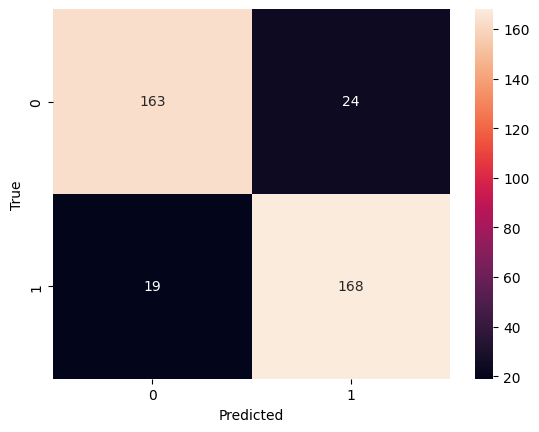

In [33]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [34]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       187
           1       0.88      0.90      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



### Inference

In [35]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until March 31, 2025',
    'Hey Niloy, are coming for the interview tomorrow',
    'Congratulations Niloy Sannyal, You are selected for the job post AI Engineer. You can join from Tomorrow. Address: House 17, Road 5, Gulshan 2, Dhaka',
    'You are awarded a Sony Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    "Why don't you wait 'til at least wednesday to see if you get your.",
]

In [36]:
model.predict(reviews)

1/1 [==============================] - 1s 940ms/step


array([[0.82206273],
       [0.2688882 ],
       [0.8954198 ],
       [0.8613882 ],
       [0.09663317]], dtype=float32)

## Saving models

In [37]:
model.save("tf_serving/saved_models/1/")

INFO:tensorflow:Assets written to: tf_serving/saved_models/1/assets


INFO:tensorflow:Assets written to: tf_serving/saved_models/1/assets


In [38]:
model.save("tf_serving/saved_models/2/")

INFO:tensorflow:Assets written to: tf_serving/saved_models/2/assets


INFO:tensorflow:Assets written to: tf_serving/saved_models/2/assets


In [39]:
model.save("tf_serving/saved_models/3/")

INFO:tensorflow:Assets written to: tf_serving/saved_models/3/assets


INFO:tensorflow:Assets written to: tf_serving/saved_models/3/assets
